## This notebook is used for examining camera QE, read noise, full well and gain, by amplifier
This is based on Steve Ritz's notebook
https://github.com/smr456/raftexplorer/blob/master/rexplorer.ipynb

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy as sc
import textwrap
import pickle
from scipy.interpolate import CubicSpline
from shutil import copy
import pandas as pd

%matplotlib inline

In [2]:
#Based on camera confluence page:
# https://confluence.slac.stanford.edu/display/LSSTCAM/Raft+Delivery+and+Acceptance+Testing+Status

#bay, run, order, vendor = 'R01 10861 5 ITL'.split()  #order 5, right after the 4 corner rafts
#bay, run, order, vendor = 'R11 10669 6 e2v'.split() #order 6, 
#bay, run, order, vendor = 'R10 10517 7 ITL'.split() #used by Simon as path finder raft, 36 measurements per curve
#bay, run, order, vendor = 'R20 10928 8 ITL'.split() #order 8,
#bay, run, order, vendor = 'R30 11063 9 e2v'.split()
#bay, run, order, vendor = 'R21 10722 10 e2v'.split()
#bay, run, order, vendor = 'R22 11351 11 e2v'.split() #order 11,
#bay, run, order, vendor = 'R12 11415 12 e2v'.split() 
#bay, run, order, vendor = 'R02 10982 13 ITL'.split() 
#bay, run, order, vendor = 'R31 11903 14 e2v'.split() 
#bay, run, order, vendor = 'R03 11166 15 ITL'.split() 
#bay, run, order, vendor = 'R34 12027 16 e2v'.split() #confluence page is wrong about slot. R34 according to Richard's tool
#bay, run, order, vendor = 'R13 11808 17 e2v'.split() 
#bay, run, order, vendor = 'R23 11852 18 e2v'.split() 
#bay, run, order, vendor = 'R14 11746 19 e2v'.split() 
bay, run, order, vendor, dataset = 'R32 12002 20 e2v 2'.split() 
#bay, run, order, vendor = 'R24 11952 21 e2v'.split() 
#bay, run, order, vendor = 'R41 12086 22 ITL'.split() 
#bay, run, order, vendor = 'R42 12120 23 ITL'.split() #Richard's notebook has 12130
#bay, run, order, vendor = 'R33 12139 24 e2v'.split() 
#bay, run, order, vendor = 'R43 11671 25 ITL'.split() 

In [3]:
if dataset==1:
    srcDir = '/home/bxin/notebooks/raftexplorer/'
else:
    srcDir = '/home/bxin/notebooks/raftResults2020jan/'
    
filename='RaftRun'+str(run)+'.p'
pkpath = os.path.join(srcDir,filename)

f=open(pkpath,'rb')
raft_name=pickle.load(f)
res=pickle.load(f)
ccd_list=pickle.load(f)
file_list=pickle.load(f)
fw=pickle.load(f)
gains=pickle.load(f)
#print(fw)
f.close()

In [4]:
raft_name

'LCA-11021_RTM-015'

In [5]:
ccd_list

[('E2V-CCD250-293', 'S00', 'LCA-13574-070'),
 ('E2V-CCD250-187', 'S01', 'LCA-13574-070'),
 ('E2V-CCD250-238', 'S02', 'LCA-13574-070'),
 ('E2V-CCD250-245', 'S10', 'LCA-13574-072'),
 ('E2V-CCD250-386', 'S11', 'LCA-13574-072'),
 ('E2V-CCD250-247', 'S12', 'LCA-13574-072'),
 ('E2V-CCD250-261', 'S20', 'LCA-13574-073'),
 ('E2V-CCD250-286', 'S21', 'LCA-13574-073'),
 ('E2V-CCD250-129', 'S22', 'LCA-13574-073')]

In [6]:
print(ccd_list[0][0][:3], vendor)
assert ccd_list[0][0][:3] == vendor.upper()

E2V e2v


In [7]:
if (ccd_list[0][0][0:3]=='ITL'):
    imark='^'
    rcolor='b'
else:
    imark='o'
    rcolor='r'
cmap = { 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'k',7:'gray',8:'orange',9:'darkslateblue',10:'coral',11:'darkblue',12:'darkred'}

E2V-CCD250-293_QE.fits
E2V-CCD250-187_QE.fits
E2V-CCD250-238_QE.fits
E2V-CCD250-245_QE.fits
E2V-CCD250-386_QE.fits
E2V-CCD250-247_QE.fits
E2V-CCD250-261_QE.fits
E2V-CCD250-286_QE.fits
E2V-CCD250-129_QE.fits


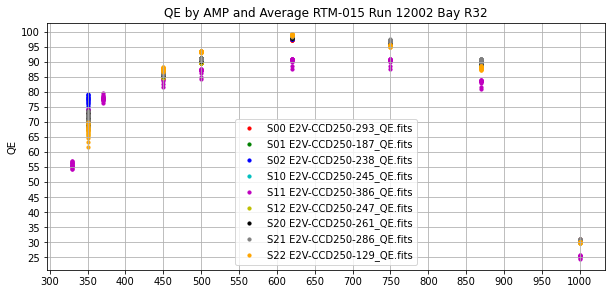

In [8]:
# define figure size parameters to make figures larger than default
figwidth=10
figheight=10

qesimple=np.zeros((100,17,9)) #iamp = 0 is not used

fig1=plt.figure(1,[figwidth,figheight])
plt.subplot(211)
plt.title('QE by AMP and Average '+raft_name[raft_name.index("RTM"):]+' Run '+run + ' Bay '+bay)
plt.ylabel('QE')
ax=fig1.gca()
ax.grid(True)
ax.set_xticks(np.arange(300, 1150, 50.))
ax.set_yticks(np.arange(0, 110., 5.))
    
for i in range (0,9):
    filename=str(ccd_list[i][0]+'_QE.fits')
    filepath = os.path.join(srcDir,run, filename)
    print(filename)
    try:
        hdulist=fits.open(filepath)
        qedata=hdulist[1].data # 1 contains the qe curves, 2 contains the band qe. See hdulist.info()
    except FileNotFoundError:
        print('FileNotFoundError: {} '.format(filename))
        continue

    wavelength=qedata['WAVELENGTH']
    for iamp in range (1,17):
        if (iamp<10):
            samp='AMP0'+str(iamp)
        else:
            samp='AMP'+str(iamp) 
        
        qedata[samp][np.where(np.isnan(qedata[samp]))] = 0
        if np.max(qedata[samp])>150:
            print('These seem too LARGE ', ccd_list[i][1], ' Amp= ', iamp)
            print(qedata[samp])
            qedata[samp][np.where(qedata[samp]>100)] = 0
        qesimple[:qedata[samp].shape[0],iamp,i]=qedata[samp]
        if iamp == 1:
            plt.scatter(wavelength,qedata[samp],10,cmap[i],imark, label='%s %s'%(ccd_list[i][1], filename))
        else:
            plt.scatter(wavelength,qedata[samp],10,cmap[i],imark)
plt.legend()

pltDir = os.path.join('cam_plots', bay)
if not os.path.exists(pltDir):
    os.mkdir(pltDir)
pngPath = os.path.join(pltDir, 'QE_%s.png'%bay)
plt.savefig(pngPath)

In [9]:
# there are more compact ways to take the mean of the non-zero segments, but this is clearest
qeraft=np.zeros(len(wavelength))
nseg=0
for iccd in range(0,9):
    nseg+=np.count_nonzero(qesimple[0,1:17,iccd])
    print("for ccd ",iccd," number of nonzero segments is", np.count_nonzero(qesimple[0,1:17,iccd]))
    for iwave in range(0,len(wavelength)):
        for iamp in range (1,17):
            qeraft[iwave]+=qesimple[iwave,iamp,iccd]

for ccd  0  number of nonzero segments is 16
for ccd  1  number of nonzero segments is 16
for ccd  2  number of nonzero segments is 16
for ccd  3  number of nonzero segments is 16
for ccd  4  number of nonzero segments is 16
for ccd  5  number of nonzero segments is 16
for ccd  6  number of nonzero segments is 16
for ccd  7  number of nonzero segments is 16
for ccd  8  number of nonzero segments is 16


nseg = 144
Number of data points in QE measurements = 7
[10014.06258774 12190.63595581 12872.5044632  13912.87360382
 13718.73566437 12911.95574188  5337.93773651]


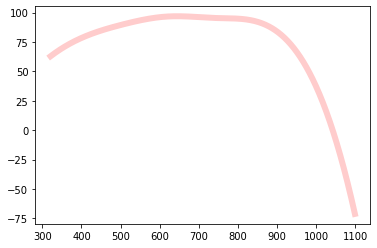

In [10]:
lambda1=np.arange(321,1100,1)           
print('nseg = {}'.format(nseg))
print('Number of data points in QE measurements = %d'%qeraft.shape[0])
print(qeraft)
qeraft=qeraft/nseg
qe=CubicSpline(wavelength, qeraft)
qecurve=qe(lambda1)
plt.plot(lambda1, qecurve,rcolor,linewidth=6,label='average',alpha=0.2)
plt.show()

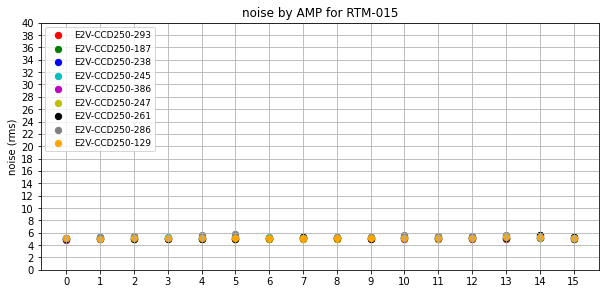

In [11]:
# now plot the noise
fig2=plt.figure(2,[figwidth,figheight])
plt.subplot(211)
plt.title('noise by AMP for '+raft_name[raft_name.index("RTM"):])
plt.ylabel('noise (rms)')
ax=fig2.gca()
ax.grid(True)
ax.set_xticks(np.arange(0, 16, 1.))
ax.set_yticks(np.arange(0, 50., 2.))
ax.set_ylim([0.,40.])
iseg=np.arange(0,16,1)
icol=0
for ccd, noise in res.items(): 
    #print(ccd)
    #print(noise)
    plt.scatter(iseg,noise,40,cmap[icol],imark,label=ccd)
    icol+=1
plt.legend(loc='upper left',prop={'size':9})

pngPath = os.path.join(pltDir, 'RN_%s.png'%bay)
plt.savefig(pngPath)

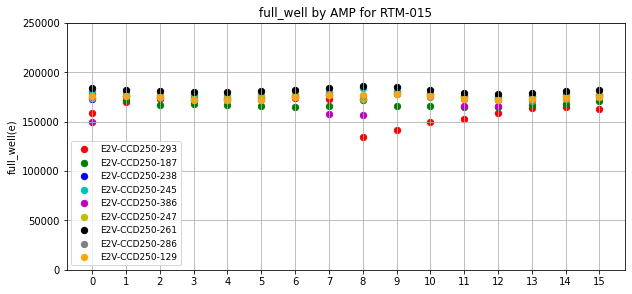

In [12]:
fig3=plt.figure(3,[figwidth,figheight])
plt.subplot(211)
plt.title('full_well by AMP for '+raft_name[raft_name.index("RTM"):])
plt.ylabel('full_well(e)')
ax=fig3.gca()
ax.grid(True)
ax.set_xticks(np.arange(0, 16, 1.))
#ax.set_yticks(np.arange(0, 50., 2.))
ax.set_ylim([0.,250000.])
iseg=np.arange(0,16,1)
icol=0
for ccd, fullwell in fw.items(): 
    plt.scatter(iseg,fullwell,40,cmap[icol],imark,label=ccd)
    icol+=1
plt.legend(loc='lower left',prop={'size':9})
    
pngPath = os.path.join(pltDir, 'FW_%s.png'%bay)
plt.savefig(pngPath)    

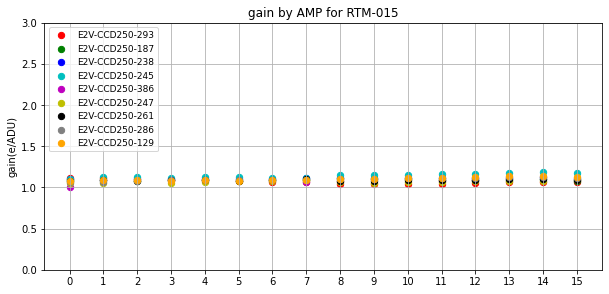

In [13]:
fig4=plt.figure(4,[figwidth,figheight])
plt.subplot(211)
plt.title('gain by AMP for '+raft_name[raft_name.index("RTM"):])
plt.ylabel('gain(e/ADU)')
ax=fig4.gca()
ax.grid(True)
ax.set_xticks(np.arange(0, 16, 1.))
#ax.set_yticks(np.arange(0, 50., 2.))
ax.set_ylim([0.,3.])
iseg=np.arange(0,16,1)
icol=0
for ccd, gain in gains.items(): 
    plt.scatter(iseg,gain,40,cmap[icol],imark,label=ccd)
    icol+=1
plt.legend(loc='upper left',prop={'size':9})

pngPath = os.path.join(pltDir, 'gain_%s.png'%bay)
plt.savefig(pngPath)

### If everything looks fine, write this raft to the installation record

In [14]:
raftInstallFile = 'raftInstall.csv'
dd = pd.read_csv(raftInstallFile, index_col=0)
dd.loc[bay, 'rtm'] = raft_name[-7:]
dd.loc[bay, 'order'] = order
dd.loc[bay, 'vendor'] = vendor
dd.loc[bay, 'run'] = run
dd.to_csv(raftInstallFile)

In [15]:
destDir = '/project/shared/bxin/cam_as_built/%s/'%(bay)
if not os.path.exists(destDir):
    os.mkdir(destDir)

filename='RaftRun'+str(run)+'.p'    
if not os.path.isfile('{}/{}'.format(destDir, filename)):
    print('coping %s to %s'%(pkpath, destDir))
    copy(pkpath, destDir)

for i in range (0,9):
    filename=str(ccd_list[i][0]+'_QE.fits')
    filepath = os.path.join(srcDir,run,filename)
    #print(filename)

    if not os.path.isfile('{}/{}'.format(destDir, filename)):
        print('coping %s to %s'%(filepath, destDir))
        copy(filepath, destDir)

coping /home/bxin/notebooks/raftResults2020jan/RaftRun12002.p to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-293_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-187_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-238_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-245_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-386_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-247_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-261_QE.fits to /project/shared/bxin/cam_as_built/R32/
coping /home/bxin/notebooks/raftResults2020jan/12002/E2V-CCD250-286_QE